/tmp/ipykernel_114035/1873687834.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


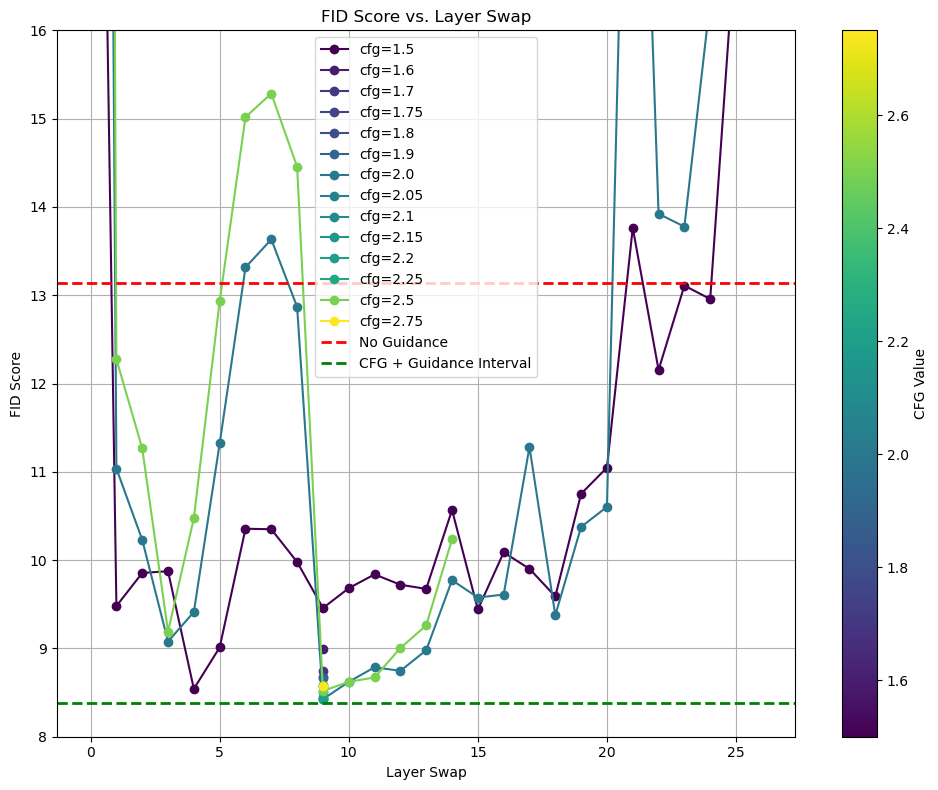

In [107]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from collections import defaultdict

# Directory containing the .txt files
DIRECTORY = "."

cfg_interval = 8.377
no_guidance = 13.14

# Regex to capture the cfg value and skip value from the filename
filename_pattern = re.compile(r'cfg-([0-9.]+).*?skip-\[(\d+)\]')
# Regex to capture the FID score from the file content
fid_pattern = re.compile(r'FID:\s*([0-9.]+)')

# Data structure: data[cfg_value][skip_value] = fid_score
data = defaultdict(dict)

# --- Read all TXT files in the directory that start with "EXP-SWAP" ---
for fname in os.listdir(DIRECTORY):
    if fname.startswith("EXP-SWAP") and fname.endswith(".txt"):
        # Extract cfg and skip from the filename
        match = filename_pattern.search(fname)
        if match:
            cfg_value_str = match.group(1)
            skip_value_str = match.group(2)

            # Convert to float (cfg) and int (skip)
            try:
                cfg_value = float(cfg_value_str)
                skip_value = int(skip_value_str)
            except ValueError:
                # Skip if numeric conversion fails
                continue

            # Read the file to find the FID value
            full_path = os.path.join(DIRECTORY, fname)
            with open(full_path, 'r') as f:
                content = f.read()

            fid_match = fid_pattern.search(content)
            if fid_match:
                fid_score_str = fid_match.group(1)
                try:
                    fid_score = float(fid_score_str)
                except ValueError:
                    continue

                data[cfg_value][skip_value] = fid_score

# --- Plotting ---
# Check if we have any data at all
if not data:
    print("No valid data found.")
    exit()

cfg_values = sorted(data.keys())

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare color normalization from min_cfg to max_cfg
min_cfg = min(cfg_values)
max_cfg = max(cfg_values)
norm = mcolors.Normalize(vmin=min_cfg, vmax=max_cfg, clip=True)
cmap = cm.get_cmap('viridis')

# Loop over each CFG value and plot skip vs FID
for cfg_value in cfg_values:
    skip_vals = sorted(data[cfg_value].keys())
    fid_scores = [data[cfg_value][skip_val] for skip_val in skip_vals]

    # Map the CFG value to a color
    color = cmap(norm(cfg_value))
    ax.plot(skip_vals, fid_scores, marker='o', color=color, label=f"cfg={cfg_value}")

plt.axhline(y=no_guidance, color='red', linestyle='--', linewidth=2, label='No Guidance')
plt.axhline(y=cfg_interval, color='green', linestyle='--', linewidth=2, label='CFG + Guidance Interval')
plt.ylim(8, 16)

# Create a “dummy” mappable for the colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # For older Matplotlib versions, so the colorbar knows the data range

# Attach the colorbar to the current figure and axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('CFG Value', rotation=90)

# Labels and legend
ax.set_title("FID Score vs. Layer Swap")
ax.set_xlabel("Layer Swap")
ax.set_ylabel("FID Score")
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()


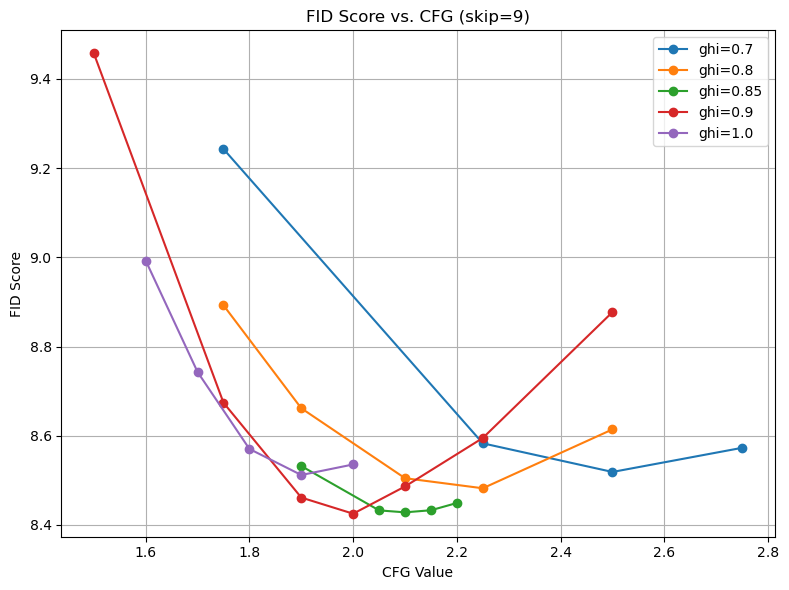

In [108]:
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to directory containing the .txt files
DIRECTORY = "."

# Regex to capture cfg, ghi, and skip from the filename.
# Example filename snippet:
#   "cfg-2.0-...-ghi-0.9-...-skip-[9]-..."
filename_pattern = re.compile(r'cfg-([0-9.]+).*?ghi-([0-9.]+).*?skip-\[([0-9]+)\]')

# Regex to capture the FID score inside the file
# We'll look for "FID: " followed by a number
fid_pattern = re.compile(r'FID:\s*([0-9.]+)')

# Data structure: data[ghi_value][cfg_value] = fid_score
data = defaultdict(dict)

# --- 1) Iterate over matching files in the directory ---
for fname in os.listdir(DIRECTORY):
    # Only process files that start with EXP-SWAP and end with .txt
    if fname.startswith("EXP-SWAP") and fname.endswith(".txt"):
        # Match the filename pattern to extract cfg, ghi, and skip
        match = filename_pattern.search(fname)
        if match:
            cfg_str, ghi_str, skip_str = match.groups()
            try:
                cfg_val = float(cfg_str)
                ghi_val = float(ghi_str)
                skip_val = int(skip_str)
            except ValueError:
                # Skip if conversion fails
                continue

            # --- 2) Focus only on files with skip = 9 ---
            if skip_val != 9:
                continue

            # --- 3) Read the file content and parse out FID ---
            full_path = os.path.join(DIRECTORY, fname)
            with open(full_path, "r") as f:
                content = f.read()

            fid_match = fid_pattern.search(content)
            if fid_match:
                try:
                    fid_score = float(fid_match.group(1))
                except ValueError:
                    continue
                
                # Store the FID in our data structure
                data[ghi_val][cfg_val] = fid_score

# --- 4) Plotting: x-axis = cfg, y-axis = FID, lines grouped by ghi ---
if not data:
    print("No valid data found (skip=9 not present).")
    exit()

plt.figure(figsize=(8, 6))

# Sort the ghi values so we get consistent ordering
for ghi_val in sorted(data.keys()):
    # For each ghi, we have multiple cfg values
    cfg_values = sorted(data[ghi_val].keys())
    fid_values = [data[ghi_val][cfg] for cfg in cfg_values]

    plt.plot(cfg_values, fid_values, marker='o', label=f"ghi={ghi_val}")

plt.title("FID Score vs. CFG (skip=9)")
plt.xlabel("CFG Value")
plt.ylabel("FID Score")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


In [105]:
data

defaultdict(dict,
            {0.8: {2.5: 8.614193556636621,
              2.25: 8.482110027481383,
              1.9: 8.661561437156593,
              1.75: 8.892520326878525,
              2.1: 8.504669368168152},
             0.85: {2.15: 8.432830157644844,
              2.1: 8.428136457261019,
              1.9: 8.531976341348582,
              2.05: 8.432530570327003,
              2.2: 8.449090606566187},
             1.0: {1.6: 8.992817774465777,
              2.0: 8.535521607086878,
              1.8: 8.570297504449513,
              1.9: 8.511848204027388,
              1.7: 8.742930336476206},
             0.9: {1.5: 9.457498441611051,
              2.25: 8.594904808273384,
              1.9: 8.461283094747614,
              2.0: 8.425074323010392,
              2.5: 8.877257059337467,
              2.1: 8.486189836013068,
              1.75: 8.673974951346793},
             0.7: {2.75: 8.57284575700669,
              2.5: 8.51869963585483,
              2.25: 8.5828866626318